# Welcome to the AI-Smörgåsbord
Lets see whats on the table...


<div style="text-align: center;">
<img src='../images/smargasbord.png' width='500' height='500'>
</div>


In [54]:
#imports
import os
from open_agent import OpenAgent
from config import Config
import pygame
from PIL import Image
from IPython.display import display
from pydantic import BaseModel 
from pydantic_core import from_json
from diffusers.utils import load_image, make_image_grid
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import torch

# Create an Agent
This will create an agent that is capable of talking to the OpenAI APIs

In [4]:
agent = OpenAgent(api_key=Config.api_key)

In [5]:
def play_sound(file):
    pygame.mixer.init()
    pygame.mixer.music.load(file)
    pygame.mixer.music.play()
    # while pygame.mixer.music.get_busy():
    #     pygame.time.Clock().tick(10)

# Text to speach
We are able to take text and convert it into speach, lets try that


In [6]:
text = 'Who knows what AI will be able to do in the future?'
target_file_name = '../data/aimagic.mp3'
agent.text_to_speach(text=text, target_file_name=target_file_name)
print('done generating file, lets play it')






done generating file, lets play it


In [7]:
# Get full path to the file and play it
full_path = os.path.abspath(target_file_name)
play_sound(full_path)

# Transcribe text from an audio file
Lets see if we can take an audio file and convert it back to text

In [8]:
response = agent.transcribe(full_path)
print(response)

Who knows what AI will be able to do in the future?


# Translate text
Lets translate a piece of text

In [10]:
text='The meaning of life is forty two'
response = agent.translate_text(text=text, target_language='german')
print(response)

#Also lets let it speak the translation
target_file_name = '../data/aimagic2.mp3'
agent.text_to_speach(text=response, target_file_name=target_file_name)
print('done generating file, lets play it')

# Get full path to the file and play it
full_path = os.path.abspath(target_file_name)
play_sound(full_path)

Der Sinn des Lebens ist zweiundvierzig.
done generating file, lets play it


# Generate images
Lets generate an image using a prompt

done generating file, lets display it


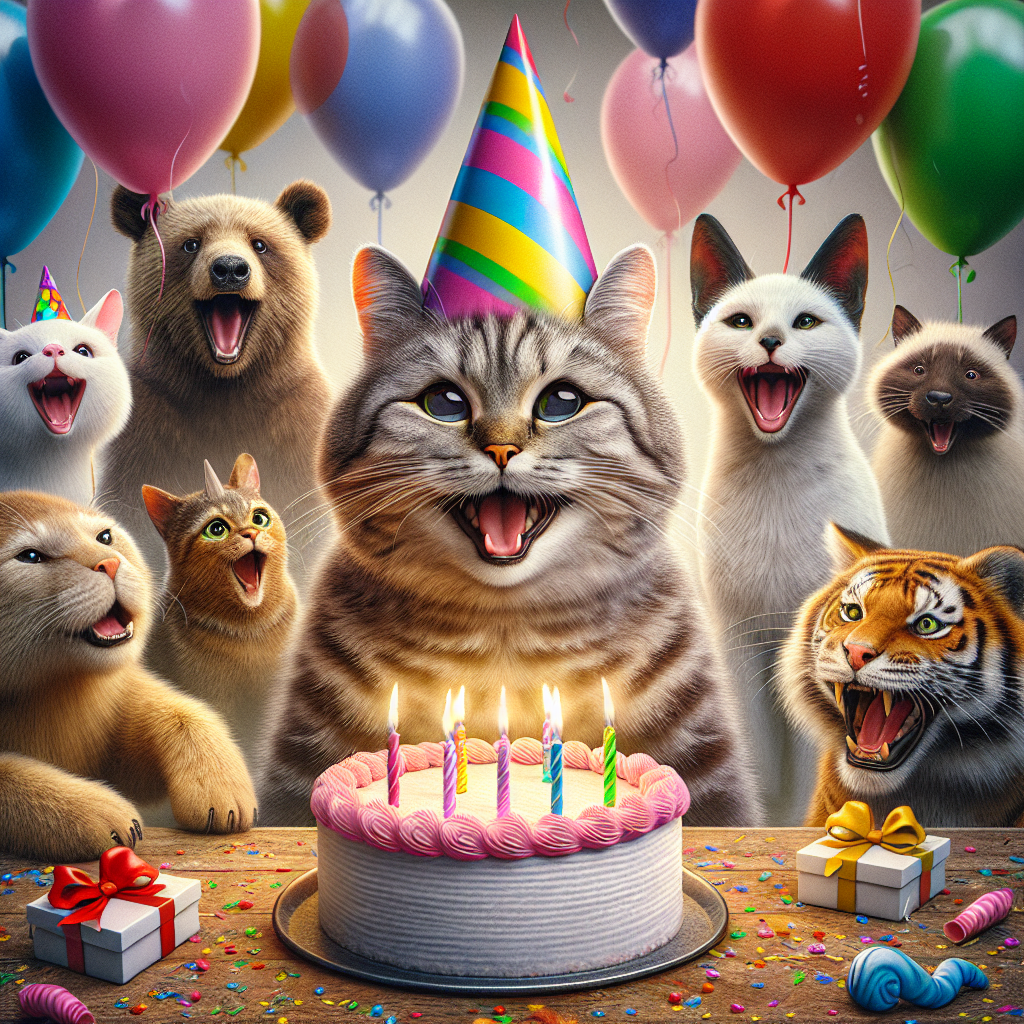

In [22]:
text = 'Image of a happy cat celebrating its birthday with its friends. The cat is wearing a party hat and there are balloons in the background. Photo realistic.'
file_path = '../data/cat_birthday.jpg'
agent.generate_image(text=text, target_file_name=file_path)
print('done generating file, lets display it')
img = Image.open(file_path)
display(img)

# Complex tasks using structured output
You can force the output to be in for example json format to be used in a pipeline.

In [12]:
class Step(BaseModel):
    explanation: str
    output: str

class MathResponse(BaseModel):
    steps: list[Step]
    final_answer: str

In [13]:
instructions = 'You are a helpful math tutor. Guide the user through the solution step by step.'
text='how can I solve 8x + 7 = -23'
response = agent.chat(text, instructions=instructions, response_format=MathResponse)
response

In [35]:
# Create MathResponse object from string
math_response = from_json(response)
for step in math_response['steps']:
    print(step['explanation'])
    print(step['output'])

print(f'Final Answer: {math_response['final_answer']}')

To isolate the term with x, we first need to eliminate the constant on the left side of the equation by subtracting 7 from both sides.
8x + 7 - 7 = -23 - 7
This simplifies the equation to 8x = -30.
8x = -30
Next, we need to isolate x by dividing both sides of the equation by 8.
x = -30 / 8
Now we simplify -30 / 8 to its simplest form. We can divide both the numerator and the denominator by 2.
x = -15 / 4
We can also express -15/4 as a decimal or a mixed number if needed. -15/4 equals -3.75 or -3 3/4.
x = -3.75 or x = -3 3/4
Final Answer: x = -3.75 or x = -3 3/4


# Can you query a set of images?
You can take a bunch of images and compress them into a latent space representation. This can then be used to calculate how similar images are. You can also query an image using text!

In [43]:
#Get the path of all images in the directory
import os
image_dir = '../images/dataset_super_heroes/'
supported_formats = ['png', 'jpg', 'jpeg']
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.split('.')[-1] in supported_formats]

#Open all images and display it as a 3x3 grid
images = [Image.open(f) for f in image_files]
    


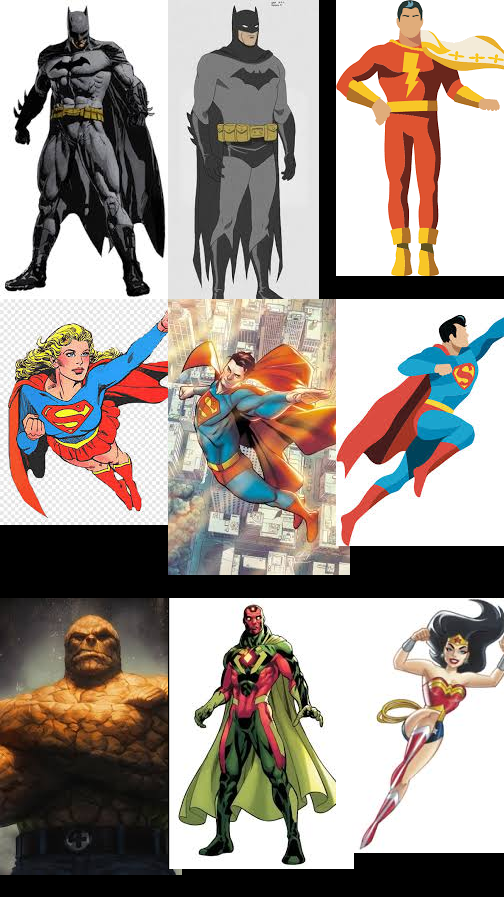

In [51]:
make_image_grid(images, 3,3, resize=None)

# Create a vector represetation of the images

In [53]:
# Load the CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

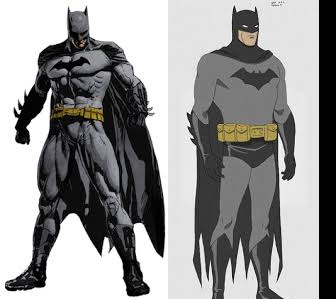

In [165]:
text = 'an image man in bat suit'
inputs = processor(text=[text],
                    images=images,
                    return_tensors="pt",
                    padding=True)
with torch.no_grad():
    outputs = model(**inputs)

#Arg sort the images based on similarity (higher is better)
ids = outputs['logits_per_image'].squeeze().argsort(descending=True)

#Show top 2 images
k = 2
images_to_show = [images[ids[i]] for i in range(k)]
make_image_grid(images_to_show, 1, k, resize=None)


# Stable Diffusion
We can also produce our own images using open source tools like Stable Diffusion

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


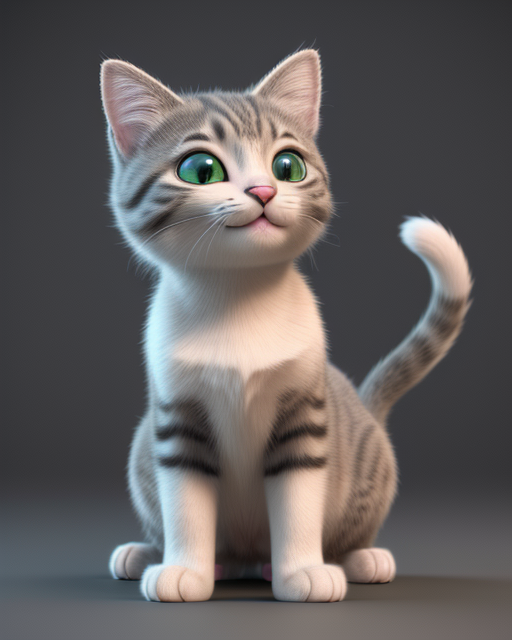

In [168]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

# Model path and settings
model_path = 'stablediffusionapi/realistic-vision-v51'
seed = 2822166962  # Use the seed from the web UI
num_inference_steps = 20
height = 640  # Height from Size: 512x640
width = 512   # Width from Size: 512x640
guidance_scale = 7  # Correct parameter name

prompt = 'professional 3d model a cute cartoon cat . octane render, highly detailed, volumetric, dramatic lighting'
negative_prompt = 'ugly, deformed, noisy, low poly, blurry, painting'

# Load the pipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)

pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

pipeline.to("cuda")

# Create a torch Generator with the specified seed
generator = torch.Generator("cuda").manual_seed(seed)

# Generate the image with all parameters matching the web UI
image = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=generator,
    height=height,
    width=width
).images[0]

# Display the image
display(image)